## Load libraries

In [1]:
from tensorflow.keras.datasets import mnist

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from keras.utils import to_categorical
from keras import backend as K

import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

import sklearn.metrics
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture

## Load and prepare the MNIST data set

In [2]:
(x_train, y_train), (x_test, y_test) = (mnist.load_data())

In [3]:
x_train = x_train.reshape(-1, 28*28).astype("float")/255
x_test = x_test.reshape(-1, 28*28).astype("float")/255

## Reuse some functions

In [4]:
def plot_latent_space(z, labels, centroids = None, figsize=(10,10), legend_title = "Labels", alpha=0.2):
    """
    Draw a 2D scatterplot of the latent space
    """
    
    plt.figure(figsize=figsize)
    scatter = plt.scatter(z[:,0], z[:,1], label=labels, c=labels, cmap="tab10", alpha=alpha, linewidths=0)

    if centroids is not None:
        plt.scatter(centroids[:,0], centroids[:,1], c="black", marker="x")
        
    leg = plt.legend(*scatter.legend_elements(), title=legend_title)
    # Make points in legend opaque
    for lh in leg.legendHandles: 
        # lh._legmarker.set_alpha(1) # old version of matplotlib
        lh.set_alpha(1)

    plt.show()

In [5]:
def plot_clusters_vs_labels(z, labels, clusters, centroids = None, figsize=(16,8), alpha=0.2):
    """
    Draw two 2D scatterplots of the latent space side by side 
    to compare the cluster assignments with the original labels
    """
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    for ax, lab, title in zip(axes, (clusters, labels), ("Clusters", "Labels") ):
    
        scatter = ax.scatter(z[:,0], z[:,1], label=lab, c=lab, cmap="tab10", alpha=alpha, linewidths=0)

        leg = ax.legend(*scatter.legend_elements(), title=title)
        # Make points in legend opaque
        for lh in leg.legendHandles: 
            # lh._legmarker.set_alpha(1) # old version of matplotlib
            lh.set_alpha(1)
            
        if centroids is not None:
            ax.scatter(centroids[:,0], centroids[:,1], c="black", marker="x")

    plt.tight_layout()

In [6]:
def compare(dataset, encoder, decoder, labels, old_figure=None, n=5):
    """
    Takes the first n images of the dataset, passes them through the encoder and decoder,
    and shows a comparison of the original and reconstructed images.
    
    If an old_figure is passed, it adds a column to it with the new reconstruction. 
    """
    index = np.arange(0,n)
    res = 28
       
    if old_figure is not None:
        assert old_figure.shape[0] == n*res
        figure = np.zeros((old_figure.shape[0], old_figure.shape[1]+res))
        figure[0:old_figure.shape[0], 0:old_figure.shape[1]] = old_figure
    else:
        figure = np.zeros((n*res, 2*res))
        for i in index:
            figure[i*res:(i+1)*res, 0:res] = dataset[i].reshape(res, res)
    
    for i in index:
        z, _ = encoder.predict(dataset[[i]], verbose=0)
        reconstructed = decoder.predict(z, verbose=0).reshape(res, res)
        figure[i*res:(i+1)*res, figure.shape[1]-res:figure.shape[1]] = reconstructed

    plt.figure()
    # plt.axis("off")
    
    x_ticks = np.arange(res/2, figure.shape[1], res)
    assert len(labels) == len(x_ticks)
    plt.xticks(x_ticks, labels, rotation=90)
    plt.yticks([])
    
    plt.imshow(figure, cmap="Greys_r")
    
    return figure

## Construct the model

In [7]:
IMG_DIM = 28*28
LATENT_DIM = 10

In [8]:
def _reparameterize(mu, logvar):
    """Reparameterization trick.
    """
    std = K.exp(0.5 * logvar)
    eps = tf.random.normal(shape=tf.shape(mu))
    return mu + eps * std

In [9]:
# Encoder
encoder_inputs = keras.Input(shape=(IMG_DIM), name="encoder_inputs")
x = layers.Dense(512, activation="relu") (encoder_inputs)
x = layers.Dense(512, activation="relu") (x)
x = layers.Dense(2048, activation="relu") (x)
encoder_mu = layers.Dense(LATENT_DIM) (x)
encoder_logvar = layers.Dense(LATENT_DIM) (x)
encoder = models.Model(encoder_inputs, [encoder_mu, encoder_logvar], name="encoder")

# Decoder
decoder_inputs = keras.Input(shape=(LATENT_DIM), name="decoder_inputs")
x = layers.Dense(2048, activation="relu") (decoder_inputs)
x = layers.Dense(512, activation="relu") (x)
x = layers.Dense(512, activation="relu") (x)
decoder_outputs = layers.Dense(IMG_DIM, activation="sigmoid") (x)
decoder = models.Model(decoder_inputs, decoder_outputs, name="decoder")

In [10]:
encoder.summary()
decoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, 784)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 512)          401920      ['encoder_inputs[0][0]']         
                                                                                                  
 dense_1 (Dense)                (None, 512)          262656      ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 2048)         1050624     ['dense_1[0][0]']                
                                                                                            

In [11]:
class VaDE(models.Model):
    """
    Implementation of Variational Deep Embedding(VaDE)
    Original paper: https://arxiv.org/pdf/1611.05148.pdf
    Code adapted from https://github.com/mori97/VaDE/

    Args:
        n_classes (int): Number of clusters.
        data_dim (int): Dimension of observed data.
        latent_dim (int): Dimension of latent space.
    """
    
    def __init__(self, n_classes, data_dim, latent_dim, **kwargs):
        super(VaDE, self).__init__(**kwargs)

        self.n_classes = n_classes
        self.data_dim = data_dim
        self.latent_dim = latent_dim
        
        self.encoder = encoder
        self.decoder = decoder
        
        self.loss_tracker = keras.metrics.Mean(name="loss")
        
        self._pi = self.add_weight(name='pi',
                                   shape=(n_classes),
                                   initializer=tf.keras.initializers.zeros,
                                   trainable=True,
                                  )
        self.mu = self.add_weight(name='mu',
                                  shape=(n_classes, latent_dim),
                                  initializer=tf.keras.initializers.random_normal,
                                  trainable=True,
                                  )
        self.logvar =  self.add_weight(name='logvar',
                                       shape=(n_classes, latent_dim),
                                       initializer=tf.keras.initializers.random_normal,
                                       trainable=True,
                                      )
        

    
    @property
    def metrics(self):
        return [self.loss_tracker,]
    
    @property
    def weights(self):
        return K.softmax(self._pi, axis=0)

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)

    def call(self, x):
        mu, logvar = self.encode(x)
        z = _reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar

    def classify(self, x, n_samples=8):
        mu, logvar = self.encode(x)
        z = K.stack([_reparameterize(mu, logvar) for _ in range(n_samples)], axis=1)
        z = tf.expand_dims(z, 2)
        
        h = z - self.mu
        h = K.exp(-0.5 * K.sum(h * h / K.exp(self.logvar), axis=3))
        h = h / K.exp(K.sum(0.5 * self.logvar, axis=1))
        
        p_z_given_c = h / (2 * math.pi)
        p_z_c = p_z_given_c * self.weights
        y = p_z_c / K.sum(p_z_c, axis=2, keepdims=True)
        y = K.sum(y, axis=1)
        return K.argmax(y, axis=1)
    
    
    def lossfun(self, x, recon_x, mu, logvar):
        batch_size = tf.cast(tf.shape(x)[0], dtype=tf.float32)
        
        # Compute gamma ( q(c|x) )
        z = tf.expand_dims(_reparameterize(mu, logvar), 1)
        h = z - self.mu
        h = K.exp(-0.5 * K.sum((h * h / K.exp(self.logvar)), axis=2))
        h = h / K.exp(K.sum(0.5 * self.logvar, axis=1))
        p_z_given_c = h / (2 * math.pi)
        p_z_c = p_z_given_c * self.weights
        gamma = p_z_c / K.sum(p_z_c, axis=1, keepdims=True)

        h = tf.expand_dims(K.exp(logvar), 1) + K.pow((tf.expand_dims(mu, 1) - self.mu), 2)
        h = K.sum(self.logvar + h / K.exp(self.logvar), axis=2)
        loss = self.data_dim * K.sum(keras.losses.binary_crossentropy(x, recon_x)) \
            + 0.5 * K.sum(gamma * h) \
            - K.sum(gamma * K.log(self.weights + 1e-9)) \
            + K.sum(gamma * K.log(gamma + 1e-9)) \
            - 0.5 * K.sum(1 + logvar)
        loss = loss / batch_size
        return loss
    
#     #from https://github.com/slim1017/VaDE/blob/master/VaDE.py
#     def lossfun(self, x, x_decoded_mean, mu, logvar):     
#         ALPHA = 0.9
#         batch_size = tf.shape(x)[0]
        
#         z = _reparameterize(mu, logvar)
#         Z = tf.transpose(K.repeat(z, self.n_classes), perm=[0,2,1])
#         z_mean_t = tf.transpose(K.repeat(mu, self.n_classes), perm=[0,2,1])
#         z_log_var_t = tf.transpose(K.repeat(logvar, self.n_classes), perm=[0,2,1])
        
#         mu_tensor3 = tf.repeat(self.mu[tf.newaxis,:,:], batch_size, axis=0)
#         lambda_tensor3 = tf.repeat(self.logvar[tf.newaxis,:,:], batch_size, axis=0)
#         theta_tensor3 = self._pi[tf.newaxis,tf.newaxis,:] * tf.ones((batch_size, self.latent_dim, self.n_classes))

#         p_c_z = K.exp(K.sum((K.log(theta_tensor3) - 0.5 * K.log(2 * math.pi * lambda_tensor3) \
#                              - K.square(Z - mu_tensor3) / (2 * lambda_tensor3)), axis=1)) + 1e-10

#         gamma = p_c_z / K.sum(p_c_z, axis=-1, keepdims=True)
#         gamma_t = K.repeat(gamma, self.latent_dim)
        
#         loss = ALPHA * self.data_dim * keras.losses.binary_crossentropy(x, x_decoded_mean) \
#         + K.sum(0.5 * gamma_t * (self.latent_dim * K.log(math.pi * 2) \
#                                  + K.log(lambda_tensor3) \
#                                  + K.exp(z_log_var_t) / lambda_tensor3 \
#                                  + K.square(z_mean_t - mu_tensor3) / lambda_tensor3), axis=(1,2)) \
#         - 0.5 * K.sum(logvar + 1, axis=-1) \
#         # - K.sum(K.log(K.repeat_elements(self._pi[tf.newaxis,:], batch_size, 0)) * gamma, axis=-1) \
#         - K.sum(K.log(self._pi[tf.newaxis,:]) * gamma, axis=-1) \
#         + K.sum(K.log(gamma) * gamma, axis=-1)

#         return loss
    
    def train_step(self, x):
        with tf.GradientTape() as tape:
            recon_x, mu, logvar = self(x)
            loss = self.lossfun(x, recon_x, mu, logvar)
            grads = tape.gradient(loss, self.trainable_weights)
            self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
            self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

## Pretrain

In [12]:
class AutoEncoderForPretrain(models.Model):
    """Auto-Encoder for pretraining VaDE.

    Args:
        data_dim (int): Dimension of observed data.
        latent_dim (int): Dimension of latent space.
    """
    def __init__(self, data_dim, latent_dim, **kwargs):
        super(AutoEncoderForPretrain, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def encode(self, x):
        mu, _ = self.encoder(x)
        return mu

    def decode(self, z):
        return self.decoder(z)

    def call(self, x):
        z = self.encode(x)
        recon_x = self.decode(z)
        return recon_x

In [13]:
EPOCHS = 20
LEARNING_RATE = 0.001
BATCH_SIZE = 128

In [14]:
model_pretrain = AutoEncoderForPretrain(IMG_DIM, LATENT_DIM)

In [15]:
optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)

model_pretrain.compile(optimizer=optimizer,
             loss=keras.losses.BinaryCrossentropy(reduction='sum'),
            )

In [16]:
model_pretrain.fit(x_train, x_train,
                   epochs=EPOCHS,
                   batch_size=128,
                   verbose=2,
                  )

Epoch 1/20
469/469 - 2s - loss: 22.4629 - 2s/epoch - 5ms/step
Epoch 2/20
469/469 - 1s - loss: 15.0806 - 1s/epoch - 2ms/step
Epoch 3/20
469/469 - 1s - loss: 14.0808 - 1s/epoch - 3ms/step
Epoch 4/20
469/469 - 1s - loss: 13.5743 - 1s/epoch - 2ms/step
Epoch 5/20
469/469 - 1s - loss: 13.2485 - 1s/epoch - 2ms/step
Epoch 6/20
469/469 - 1s - loss: 12.9897 - 1s/epoch - 2ms/step
Epoch 7/20
469/469 - 1s - loss: 12.7912 - 1s/epoch - 2ms/step
Epoch 8/20
469/469 - 1s - loss: 12.6371 - 1s/epoch - 2ms/step
Epoch 9/20
469/469 - 1s - loss: 12.4938 - 1s/epoch - 2ms/step
Epoch 10/20
469/469 - 1s - loss: 12.3809 - 1s/epoch - 3ms/step
Epoch 11/20
469/469 - 1s - loss: 12.2691 - 1s/epoch - 2ms/step
Epoch 12/20
469/469 - 1s - loss: 12.1892 - 1s/epoch - 2ms/step
Epoch 13/20
469/469 - 1s - loss: 12.0967 - 1s/epoch - 2ms/step
Epoch 14/20
469/469 - 1s - loss: 12.0226 - 1s/epoch - 2ms/step
Epoch 15/20
469/469 - 1s - loss: 11.9503 - 1s/epoch - 2ms/step
Epoch 16/20
469/469 - 1s - loss: 11.8884 - 1s/epoch - 2ms/step
E

/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


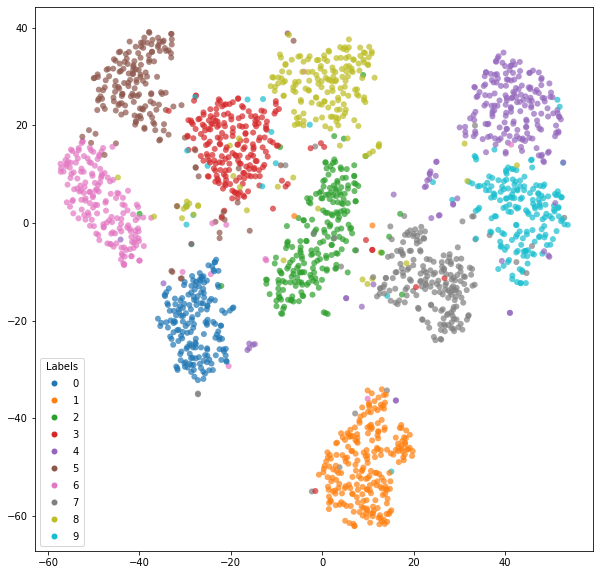

In [17]:
z = model_pretrain.encode(x_test[0:2000])

tsne = TSNE(n_components=2, init='pca')
z_tsne = tsne.fit_transform(z)
plot_latent_space(z_tsne, y_test[0:2000], alpha=0.7)

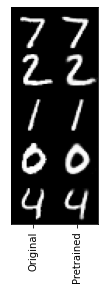

In [18]:
compare_orig_vs_pretrained = compare(x_test, encoder, decoder, ("Original", "Pretrained"))

In [19]:
encoder.save_weights("test_vade_models/encoder/pretrained")
decoder.save_weights("test_vade_models/decoder/pretrained")

## Finetune

In [20]:
encoder.load_weights("test_vade_models/encoder/pretrained")
decoder.load_weights("test_vade_models/decoder/pretrained")

In [21]:
N_CLASSES = 10

EPOCHS = 200
LEARNING_RATE = 0.002
BATCH_SIZE = 128
SCHEDULE = 10

In [22]:
model_vade = VaDE(N_CLASSES, IMG_DIM, LATENT_DIM)

In [23]:
# Initialize parameters
z_train = model_pretrain.encode(x_train)

gmm = GaussianMixture(n_components=10, covariance_type='diag')
gmm.fit(z_train)

for weight in model_vade.trainable_weights:
    if weight.name == "pi:0":
        weight.assign(K.log(K.constant(gmm.weights_)))
    elif weight.name == "mu:0":
        weight.assign(K.constant(gmm.means_))
    elif weight.name == "logvar:0":
        weight.assign(K.log(K.constant(gmm.covariances_)))

Acc: 0.8699
ARI: 0.7348
AMI: 0.7608


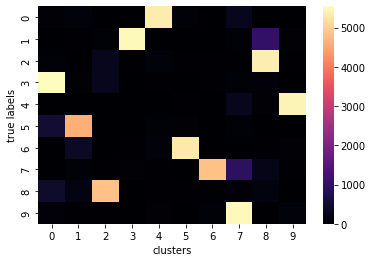

In [24]:
# EVALUATE the pretrained model
c_train = model_vade.classify(x_train)

confusion_matrix = sklearn.metrics.confusion_matrix(y_train, c_train)
heatmap = sns.heatmap(confusion_matrix,  cmap='magma')
heatmap.set(xlabel='clusters', ylabel='true labels')

clust_labels = confusion_matrix.argmax(0)[c_train]
print(f"Acc: {sklearn.metrics.accuracy_score(y_train, clust_labels):.4f}")
print(f"ARI: {sklearn.metrics.adjusted_rand_score(y_train, c_train):.4f}")
print(f"AMI: {sklearn.metrics.adjusted_mutual_info_score(y_train, c_train):.4f}")
# print(f"Sil: {sklearn.metrics.silhouette_score(z_train, c_train):.4f}")

In [25]:
def scheduler(epoch, lr):
    if (epoch+1) % SCHEDULE == 0:
        lr = lr * 0.9
    return lr

def show_state(epoch, logs):
    if (epoch+1) % SCHEDULE == 0 or epoch == 0:
        # # Plot embeddings (This makes training slow!)
        # z, _ = model_vade.encode(x_test[0:1000])
        # tsne = TSNE(n_components=2, init='pca')
        # z_tsne = tsne.fit_transform(z)
        # plot_latent_space(z_tsne, y_test[0:1000], alpha=0.7)
        
        # Print Accuracy
        c_train = model_vade.classify(x_train)
        clust_labels = confusion_matrix.argmax(0)[c_train]
        print(f"\n Current accuracy: {sklearn.metrics.accuracy_score(y_train, clust_labels):.4f}")

callback = [tf.keras.callbacks.LearningRateScheduler(scheduler),
            tf.keras.callbacks.LambdaCallback(on_epoch_end=show_state)
           ]

In [26]:
optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)

model_vade.compile(optimizer=optimizer)

In [27]:
model_vade.fit(x_train,
               epochs=EPOCHS,
               batch_size=BATCH_SIZE,
               callbacks = callback,
               # verbose=2,
              )

Epoch 1/200
469/469 [==============================] - 3s 5ms/step - loss: 104.2093 - lr: 0.0020
Epoch 2/200
469/469 [==============================] - 2s 5ms/step - loss: 102.9077 - lr: 0.0020
Epoch 3/200
469/469 [==============================] - 2s 5ms/step - loss: 102.1994 - lr: 0.0020
Epoch 4/200
469/469 [==============================] - 2s 5ms/step - loss: 101.9134 - lr: 0.0020
Epoch 5/200
469/469 [==============================] - 2s 5ms/step - loss: 101.3156 - lr: 0.0020
Epoch 6/200
469/469 [==============================] - 2s 5ms/step - loss: 100.9825 - lr: 0.0020
Epoch 7/200
469/469 [==============================] - 2s 5ms/step - loss: 100.6351 - lr: 0.0020
Epoch 8/200
469/469 [==============================] - 2s 5ms/step - loss: 100.3349 - lr: 0.0020
Epoch 9/200
469/469 [==============================] - 2s 5ms/step - loss: 100.0224 - lr: 0.0020
Epoch 10/200
469/469 [==============================] - 3s 6ms/step - loss: 99.1522 - lr: 0.0018
Epoch 11/200
469/469 [========

/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


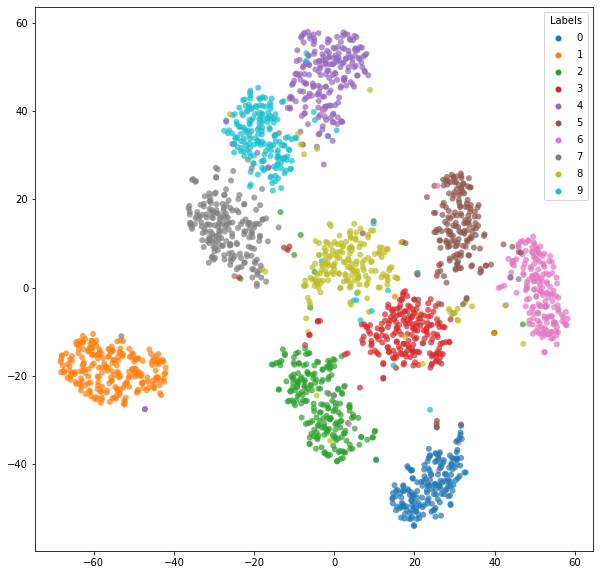

In [28]:
z, _ = model_vade.encode(x_test[0:2000])
tsne = TSNE(n_components=2, init='pca')
z_tsne = tsne.fit_transform(z)
plot_latent_space(z_tsne, y_test[0:2000], alpha=0.7)

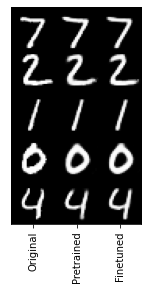

In [29]:
_ = compare(x_test, encoder, decoder, ("Original", "Pretrained", "Finetuned"), old_figure=compare_orig_vs_pretrained)

Acc: 0.9424
ARI: 0.8782
AMI: 0.8760


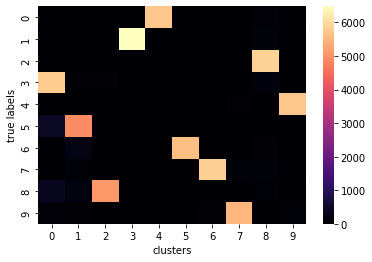

In [30]:
# EVALUATE the pretrained model
c_train = model_vade.classify(x_train)

confusion_matrix = sklearn.metrics.confusion_matrix(y_train, c_train)
heatmap = sns.heatmap(confusion_matrix,  cmap='magma')
heatmap.set(xlabel='clusters', ylabel='true labels')

clust_labels = confusion_matrix.argmax(0)[c_train]
print(f"Acc: {sklearn.metrics.accuracy_score(y_train, clust_labels):.4f}")
print(f"ARI: {sklearn.metrics.adjusted_rand_score(y_train, c_train):.4f}")
print(f"AMI: {sklearn.metrics.adjusted_mutual_info_score(y_train, c_train):.4f}")
# print(f"Sil: {sklearn.metrics.silhouette_score(z_train, c_train):.4f}")

In [31]:
encoder.save_weights("test_vade_models/encoder/finetuned")
decoder.save_weights("test_vade_models/decoder/finetuned")
model_vade.save_weights("test_vade_models/vade/finetuned")